# Import the essential libraries

In [1]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
!pip install rasterio
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

# Define the required variable

In [2]:
dataset_url = r'.\..\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [4]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [5]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


# Visualization of input datasets

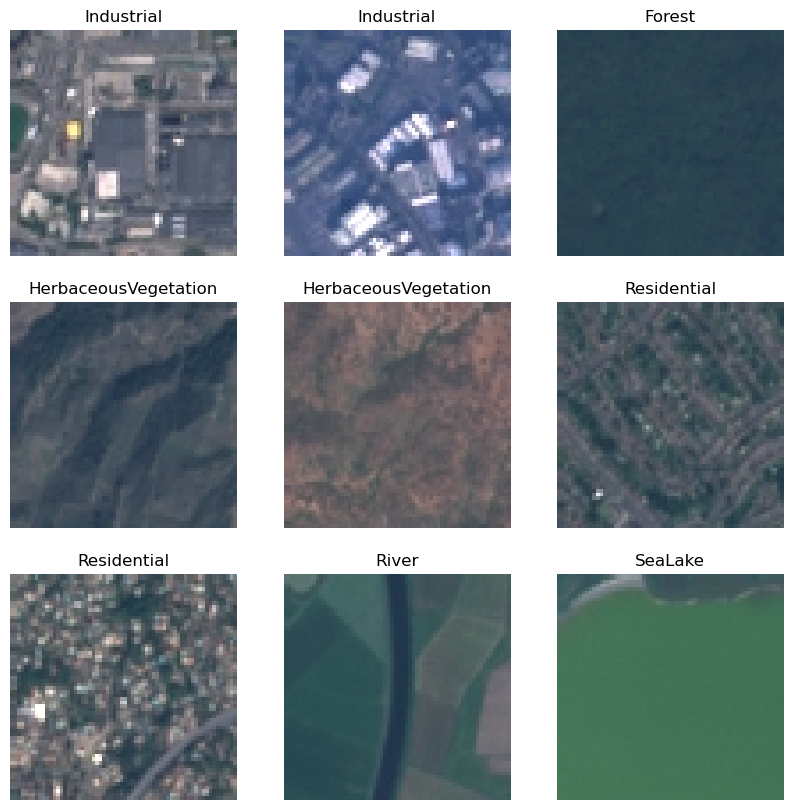

In [6]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [8]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [10]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
675/675 [==============================] - 860s 1s/step - loss: 1.7423 - accuracy: 0.4714 - val_loss: 1.2847 - val_accuracy: 0.5870
Epoch 2/20
675/675 [==============================] - 869s 1s/step - loss: 1.0514 - accuracy: 0.6409 - val_loss: 0.9915 - val_accuracy: 0.6648
Epoch 3/20
675/675 [==============================] - 886s 1s/step - loss: 0.8855 - accuracy: 0.6988 - val_loss: 1.0865 - val_accuracy: 0.6241
Epoch 4/20
675/675 [==============================] - 845s 1s/step - loss: 0.7876 - accuracy: 0.7436 - val_loss: 0.6729 - val_accuracy: 0.7719
Epoch 5/20
675/675 [==============================] - 804s 1s/step - loss: 0.7247 - accuracy: 0.7684 - val_loss: 0.9935 - val_accuracy: 0.7057
Epoch 6/20
675/675 [==============================] - 777s 1s/step - loss: 0.7152 - accuracy: 0.7659 - val_loss: 0.7492 - val_accuracy: 0.7524
Epoch 7/20
675/675 [==============================] - 772s 1s/step - loss: 0.7523 - accuracy: 0.7574 - val_loss: 0.7296 - val_accuracy: 0.7654

In [13]:
model.save('lulc_20_epoch')

INFO:tensorflow:Assets written to: lulc_20_epoch\assets


INFO:tensorflow:Assets written to: lulc_20_epoch\assets


# analyzing results and visualization

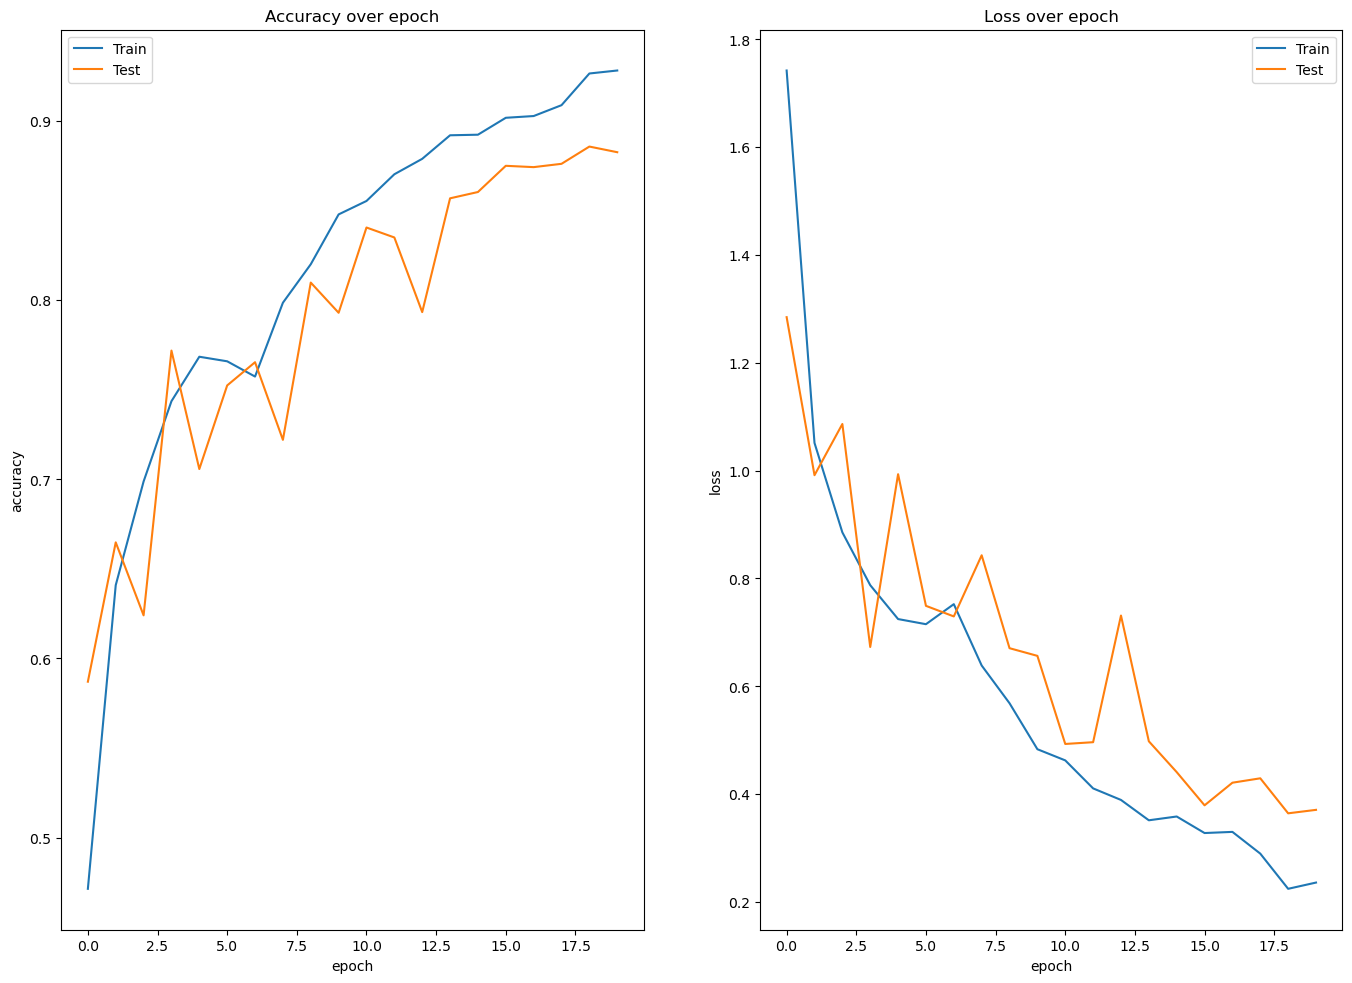

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [15]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 167ms/step


In [16]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 917,    3,    3,   22,    1,   24,   16,    2,   53,   19],
       [   2, 1022,    7,    0,    0,   13,    0,    0,    3,   13],
       [  24,   18,  815,   24,    9,   32,   99,   20,   39,    1],
       [   7,    3,    4,  804,   25,   14,    9,    6,   37,    0],
       [   1,    0,    3,   43,  794,    0,    6,   24,    9,    0],
       [  17,   21,   15,    8,    0,  609,   16,    0,   19,    1],
       [  51,    0,   39,   34,    6,   58,  660,    9,   41,    0],
       [   0,    0,    3,   22,   25,    0,    8, 1007,    2,    0],
       [  15,   10,    2,   40,    4,   23,    2,    0,  797,    2],
       [   7,   13,    0,    0,    0,    4,    0,    0,    9, 1035]],
      dtype=int64)

In [17]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 917    3    3   22    1   24   16    2   53   19]
 [   2 1022    7    0    0   13    0    0    3   13]
 [  24   18  815   24    9   32   99   20   39    1]
 [   7    3    4  804   25   14    9    6   37    0]
 [   1    0    3   43  794    0    6   24    9    0]
 [  17   21   15    8    0  609   16    0   19    1]
 [  51    0   39   34    6   58  660    9   41    0]
 [   0    0    3   22   25    0    8 1007    2    0]
 [  15   10    2   40    4   23    2    0  797    2]
 [   7   13    0    0    0    4    0    0    9 1035]]


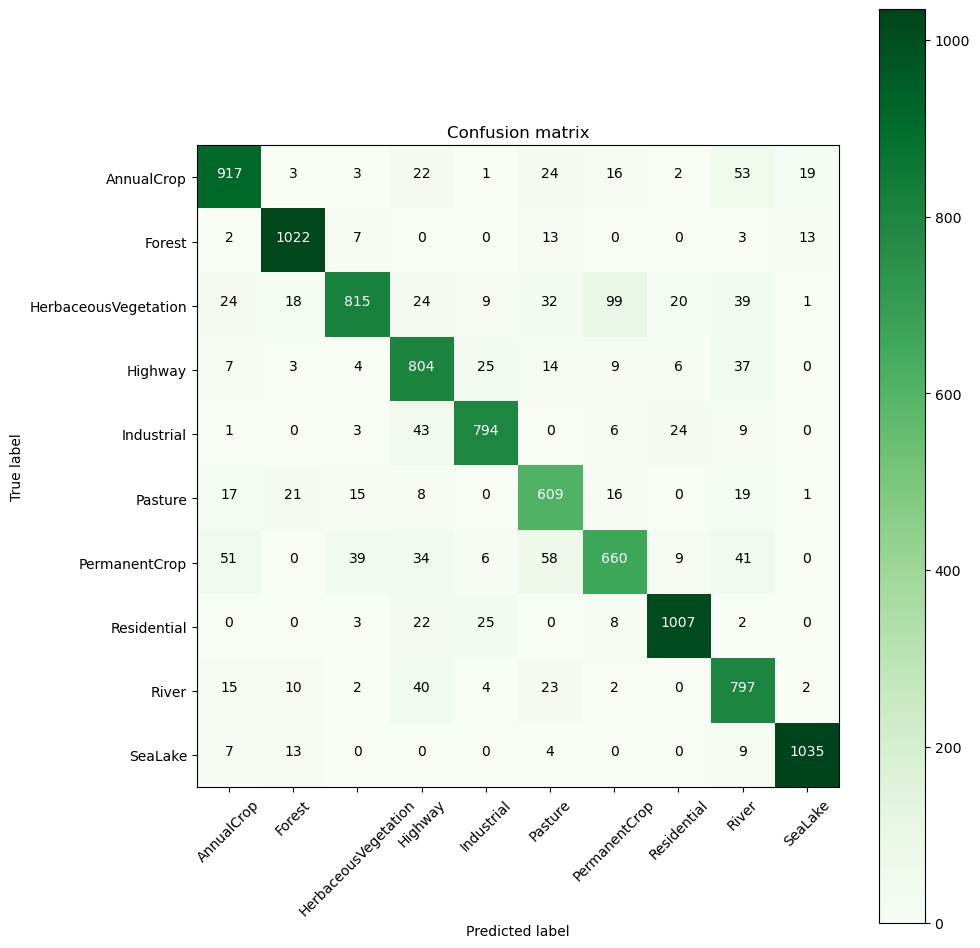

In [18]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Greens')

In [19]:
model = tf.keras.applications.ResNet101(
    include_top=False,
    input_tensor=None,
    input_shape=(64,64, 3),
    classes=10,
)
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block8_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block7_out[0][0]',       
                                                                  'conv4_block8_3_bn[0][0]']      
                                                                                                  
 conv4_block8_out (Activation)  (None, 4, 4, 1024)   0           ['conv4_block8_add[0][0]']       
                                                                                                  
 conv4_block9_1_conv (Conv2D)   (None, 4, 4, 256)    262400      ['conv4_block8_out[0][0]']       
                                                                                                  
 conv4_block9_1_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block9_1_conv[0][0]']    
 ization) 

 conv4_block11_out (Activation)  (None, 4, 4, 1024)  0           ['conv4_block11_add[0][0]']      
                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, 4, 4, 256)    262400      ['conv4_block11_out[0][0]']      
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_1_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 4, 4, 256)    590080      ['conv4_block15_1_relu[0][0]']   
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block18_2_conv (Conv2D)  (None, 4, 4, 256)    590080      ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_2_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block18_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block18_2_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block18_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_3_conv (Conv2D)  (None, 4, 4, 1024)   263168      ['conv4_block18_2_relu[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block21_2_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block21_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 4, 4, 1024)   263168      ['conv4_block21_2_relu[0][0]']   
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, 4, 4, 1024)  4096        ['conv4_block21_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block21_add (Add)        (None, 4, 4, 1024)   0           ['conv4_block20_out[0][0]',      
                                                                  'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
          

# Load model

In [20]:
from tensorflow.keras.models import load_model
model = load_model(r"lulc_20_epoch")

# Thank you 